In [20]:
import os
import sys
import re
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from tqdm import tqdm
from IPython.display import clear_output
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import time

# Supress RDKit warnings
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')


In [39]:
# import txt file
def import_library(path):
    with open(path, 'r') as f:
        file = f.readlines()
    return file

def retrieve_spectra(GNPS_ID, Library):
    ID = str(GNPS_ID).strip()
    # print(ID)
    if ID is None:
        print("Error: No ID provided")
        return None
    if "CCMSLIB" in ID:
        # print("The ID is formatted correctly")
        pass
    else:
        print("Error: The provided ID is not in the correct format or is not a GNPS_ID")
        return None
    GNPS_ID_formatted = "SPECTRUMID=" + ID + "\n"
    GNPS_ID_index = Library.index(GNPS_ID_formatted)
    # print("Spectrum ID index: " + str(GNPS_ID_index))
    begin_ion = (int(GNPS_ID_index) - 18)
    # print("Begin ion index: " + str(begin_ion))
    # Using the index of the GNPS_ID, we can find the beginning of the spectra and the end of the spectra
    # Starting at the GNPS_ID_index, continue iterating through the library to find the "END IONS/n" string
    end_ion = None
    for i in range(GNPS_ID_index, len(Library)):
        if Library[i] == "END IONS\n":
            end_ion = i
            break
    # print("End ion index: " + str(end_ion))
    return Library[begin_ion:end_ion+1]

def retrieve_spectra_fast(GNPS_ID, Library, index):
    ID = str(GNPS_ID).strip()
    # print(ID)
    if ID is None:
        print("Error: No ID provided")
        return None
    if "CCMSLIB" in ID:
        # print("The ID is formatted correctly")
        pass
    else:
        print("Error: The provided ID is not in the correct format or is not a GNPS_ID")
        return None
    GNPS_ID_index = index
    # print("Spectrum ID index: " + str(GNPS_ID_index))
    begin_ion = (int(GNPS_ID_index) - 18)
    # print("Begin ion index: " + str(begin_ion))
    # Using the index of the GNPS_ID, we can find the beginning of the spectra and the end of the spectra
    # Starting at the GNPS_ID_index, continue iterating through the library to find the "END IONS/n" string
    end_ion = None
    for i in range(GNPS_ID_index, len(Library)):
        if Library[i] == "END IONS\n":
            end_ion = i
            break
    # print("End ion index: " + str(end_ion))
    return Library[begin_ion:end_ion+1]

def write_mgf(spectra, GNPS_ID, ion, output_path):
    ID = str(GNPS_ID).strip()
    ion = str(ion).strip()
    # Get the index of the spectrum id entry in the spectra list
    SPECTRUMID_index = spectra.index("SPECTRUMID=" + ID + "\n")
    # Get SMILES entry using regex
    try:
        smiles = re.search(r'SMILES=(.*)\n', spectra[12]).group(1)
        # Get the exact mass of smiles using RDKit
        mol = Chem.MolFromSmiles(smiles)
        exact_mass = Chem.rdMolDescriptors.CalcExactMolWt(mol)
        # Replace the PEPMASS entry with the correct exact mass
        spectra[1] = "PEPMASS=" + ("%.5f" % exact_mass) + "\n"
    except:
        pass
    # Replace the spectrum id entry with the correct spectrum id
    spectra[SPECTRUMID_index] = "SPECTRUMID=" + ID + "\n" + "FEATURE_ID=" + ID + "\n" + "POLARITY=POS\n" + "ION=[M+" + ion + "]+\n"
    # Delete the lines containing 'INCHI=' and 'INCHIAUX=' and "SMILES="
    with open(output_path + "/" + ID + ".mgf", 'w') as f:
        for line in spectra:
            f.write(line)
    return None

def basic_substructure_search(Substructure, Library):
    # Search for the structure in the library in all lines that start with "SMILES="
    # If the structure is found, add index to list
    matches = []
    structures = []
    for i in range(len(Library)):
        if Library[i].startswith("SMILES="):
            if Substructure in Library[i]:
                matches.append(Library[i+6].strip("SPECTRUMID").strip("=").strip("\n"))
                structures.append(Library[i].strip("SMILES=").strip("\n"))
    return matches, structures

def basic_mass_search(Mass, Library, ppm):
    # search for the mass in the library in all lines that start with "PEPMASS="
    # If the mass is found, add index to list
    matches = []
    masses = []
    # search_string = "PEPMASS=" + str(Mass) + "\n"
    ppm_error = (Mass * (ppm/1000000))
    for i in range(len(Library)):
        if Library[i].startswith("PEPMASS="):
            x =float(Library[i].strip("PEPMASS=").strip("\n"))
            if abs(x - Mass) <= ppm_error:
                matches.append(Library[i+17].strip("SPECTRUMID").strip("=").strip("\n"))
                masses.append(x)
    return matches, masses

def basic_name_search(Name, Library, num_matches=10):
    # Search for the Name in the library in all lines that start with "NAME="
    # If the name is found, add index to list
    Matches = []
    GNPS_IDs = []
    # Compile the regex
    Regex = re.compile(Name, re.IGNORECASE)
    # Search the library using list comprehension and regex, stop after the number of matches is reaches the num_matches variable. If num_matches is None, then return all matches
    if num_matches == None:
        Matches_index = [i for i in range(len(Library)) if Library[i].startswith("NAME=") if re.search(Regex, Library[i])]
    else:
        pass
    if num_matches != None:
        Matches_index = []
        for i in range(len(Library)):
            if Library[i].startswith("NAME="):
                if re.search(Regex, Library[i]):
                    Matches_index.append(i)
                    if len(Matches_index) == num_matches:
                        break
    # Get the Names from the matches index
    Matches = [Library[i] for i in Matches_index]
    Matches = [i.strip("NAME").strip("=").strip("\n") for i in Matches]
    # Get the GNPS_IDs from the matches index
    GNPS_IDs = [Library[i+9] for i in Matches_index]
    GNPS_IDs = [i.strip("SPECTRUMID").strip("=").strip("\n") for i in GNPS_IDs]
    return Matches, GNPS_IDs

def display_spectra(mgf_spectra):
    if mgf_spectra == None:
        print("Error: No spectra provided")
        return None
    # Get the mass/intensity pairs from the mgf_spectra
    mass_intensity_pairs = []
    # Starting that the line beginning with SCANS=, iterate through the mgf_spectra and append the mass/intensity pairs to the mass_intensity_pairs list. Stop when the line begins with "END IONS"
    for i in range(len(mgf_spectra)):
        if mgf_spectra[i].startswith("SCANS="):
            for j in range(i+1, len(mgf_spectra)):
                if mgf_spectra[j].startswith("END IONS"):
                    break
                else:
                    mass_intensity_pairs.append(mgf_spectra[j].strip("\n").split(" "))
    # Split each mass_intensity_pair into a mass and intensity by splitting on the tab character
    mass_intensity_pairs = [i[0].split("\t") for i in mass_intensity_pairs]
    # print(mass_intensity_pairs)
    # Make 2 lists of the masses and intensities and convert them to floats
    masses = [float(i[0]) for i in mass_intensity_pairs]
    # print(masses)
    intensities = [float(i[1]) for i in mass_intensity_pairs]
    # print(intensities)
    # Plot the mass_intensity_df using a barplot
    fig, ax = plt.subplots(figsize=(20,10))
    ax.bar(masses, intensities, width=0.8, color='#464141')
    # Retrieve the title from the mgf_spectra
    title = mgf_spectra[9].strip("NAME").strip("=").strip("\n") + "; " + mgf_spectra[18].strip("SPECTRUMID").strip("=").strip("\n") + "; " + mgf_spectra[1].strip("PEPMASS").strip("=").strip("\n") + "m/z"
    ax.set_title("Mass Spectrum of " + title, fontsize=24)
    ax.set_xlabel("Mass (m/z)", fontsize=20)
    ax.set_ylabel("Intensity", fontsize=20)
    # Set the x range
    ax.set_xlim(0, max(masses) + 10)
    # Set the x axis to be in increments of 50 with a tick every 10
    # plt.xticks(np.arange(0, mass_intensity_df["Mass"].max(), 50))
    # Remove the x labels
    # plt.xlabel("")
    # plt.show()
    return fig, ax

def display_spectra_interactive(mgf_spectra):
    # Get the mass/intensity pairs from the mgf_spectra
    mass_intensity_pairs = []
    # Starting that the line beginning with SCANS=, iterate through the mgf_spectra and append the mass/intensity pairs to the mass_intensity_pairs list. Stop when the line begins with "END IONS"
    for i in range(len(mgf_spectra)):
        if mgf_spectra[i].startswith("SCANS="):
            for j in range(i+1, len(mgf_spectra)):
                if mgf_spectra[j].startswith("END IONS"):
                    break
                else:
                    mass_intensity_pairs.append(mgf_spectra[j].strip("\n").split(" "))
    # Split each mass_intensity_pair into a mass and intensity by splitting on the tab character
    mass_intensity_pairs = [i[0].split("\t") for i in mass_intensity_pairs]
    # print(mass_intensity_pairs)
    # Make 2 lists of the masses and intensities and convert them to floats
    masses = [float(i[0]) for i in mass_intensity_pairs]
    # print(masses)
    intensities = [float(i[1]) for i in mass_intensity_pairs]
    # print(intensities)
    mass_intensity_df = pd.DataFrame({"Mass": masses, "Intensity": intensities}, columns=["Mass", "Intensity"], dtype=float)
    # print(mass_intensity_df)
    # Display using the plotly express bar chart
    title=mgf_spectra[9].strip("NAME").strip("=").strip("\n") + "; " + mgf_spectra[18].strip("SPECTRUMID").strip("=").strip("\n") + "; " + mgf_spectra[1].strip("PEPMASS").strip("=").strip("\n") + "m/z"
    fig = px.bar(mass_intensity_pairs,
                 x=0,
                 y=1,
                 title=title)
    fig.update_layout(
        xaxis_title="Mass (m/z)",
        yaxis_title="Intensity",
        font=dict(
            family="Courier New, monospace",
            size=18,
            color="#464141"
        )
    )
    fig.show()
    
def display_structure(GNPS_ID, Library):
    # Get the spectra from the library using the retrieve_spectra function
    spectra = retrieve_spectra(GNPS_ID, Library)
    # Find the line that starts with "SMILES="
    sadness_mol = Chem.MolFromSmiles("C1=CC2=C(C=C1O)C(=CN2)CCN")
    try:
        # smiles = re.search(r'SMILES=(.*)\n', spectra[:]).group(1)
        smiles = spectra[12].strip("SMILES").strip("=").strip("\n")
    except:
        print("No SMILES Found")
        
    try:
        # inchi = re.search(r'INCHI=(.*)\n', spectra[:]).group(1)
        inchi = spectra[13].strip("INCHI").strip("=").strip("\n")
    except:
        print("No InChI Found")
        
    try:
        smiles_mol = Chem.MolFromSmiles(smiles)
    except:
        pass
    try:
        inchi_mol = Chem.MolFromInchi(inchi)
    except:
        pass

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,10))
    
    if smiles_mol != None:
        img1 = Chem.Draw.MolToImage(smiles_mol, size=(1000, 1000))
        ax1.imshow(img1)
        ax1.set_title("SMILES", fontsize=24)
        ax1.axis("off")
    else:
        img1 = Chem.Draw.MolToImage(sadness_mol, size=(1000, 1000))
        ax1.imshow(img1)
        ax1.set_title("SMILES Not Found", fontsize=24)
        ax1.axis("off")
        
    if inchi_mol != None:
        img2 = Chem.Draw.MolToImage(inchi_mol, size=(1000, 1000))
        ax2.imshow(img2)
        ax2.set_title("InChI", fontsize=24)
        ax2.axis("off")
    else:
        img2 = Chem.Draw.MolToImage(sadness_mol, size=(1000, 1000))
        ax2.imshow(img2)
        ax2.set_title("InChI Not Found", fontsize=24)
        ax2.axis("off")
    
    # Display the spectra
    display_spectra(spectra)
    
    plt.show()

def input_confirm_structure(ID_structure_dict):
    # Display each structure to the user and ask for input. If input is y then return True, else return False
    # If true, add the key value pair to the dictionary to return
    # If false, do not add the key value pair to the dictionary to return
    # If the user enters "exit", exit the program

    # Create a dictionary to store the user input
    confirmed_structures = {}
    # Iterate through the dictionary and display the key value pairs to the user
    for key, value in ID_structure_dict.items():
        # print("GNPS_ID: " + key)
        # print("Structure: " + value)
        # Ask for user input
        # Display the structure to the user using RDKit
        mol = Chem.MolFromSmiles(value)
        img = Chem.Draw.MolToImage(mol)
        display(img)
        question = input("Do you want to add this structure to the dictionary? (y/n): ")
        if question == "exit":
            sys.exit()
        if question == "y" or question == "Y":
            # Add the key value pair to the dictionary to return
            confirmed_structures[key] = value
            pass
        else:
            # Do not add the key value pair to the dictionary to return
            pass
        clear_output(wait=True)
    return confirmed_structures

In [23]:
# Add the local filepath for the GNPS library you downloaded from "https://gnps-external.ucsd.edu/gnpslibrary"
gnps_library = import_library("C:/Users/nbrittin/Desktop/GNPS Libraries/ALL_GNPS_05-25-23.mgf")

In [24]:
# This will generate a list of all the GNPS IDs in the library, this can be helpful for confirming that your GNPS IDs are formatted correctly and present
# I have also used this for getting random sets of spectra to test the function of ML models.
gnps_ids = []
for i in range(len(gnps_library)):
    if gnps_library[i].startswith("SPECTRUMID="):
        gnps_ids.append(gnps_library[i].strip("SPECTRUMID").strip("=").strip("\n"))
print("Number of Spectra in the GNPS Library: ", len(gnps_ids))

Number of Spectra in the GNPS Library:  587991


In [26]:
# This will generate a dictionary of all the GNPS IDs in the library and their index in the library, this can be helpful for quickly retrieving spectra if desired. 
# It is not necessary to run this cell, but it is signficantly faster than only using the retrieve_spectra function on a large number of IDs which can take almost 30 seconds per ID to run.
# It takes miliseconds to retrieve the index using this dictionary and then miliseconds to retrieve the spectra using the retrieve_spectra_fast function
gnps_id_index_dict = {}
for i in range(len(gnps_library)):
    if gnps_library[i].startswith("SPECTRUMID="):
        gnps_id_index_dict[gnps_library[i].strip("SPECTRUMID").strip("=").strip("\n")] = i
print("Number of Spectra in the GNPS Library: ", len(gnps_id_index_dict))

Number of Spectra in the GNPS Library:  587991


In [27]:
# Example using all of the function to investigate Natamycin
# Natamycin is a polyene macrolide antibiotic that is used to treat fungal infections. It is also used as a food preservative.

# Retrieve the matches for Natamycin using the basic_name_search function
name = "Natamycin"
natamycin_matches = basic_name_search(name, gnps_library, num_matches=10)

print("Natamycin Matches: ", natamycin_matches)

Natamycin Matches:  (['Natamycin M+H', 'Natamycin M+H', 'Natamycin M+H', 'Natamycin (Pimaricin) [M+H]'], ['CCMSLIB00000004692', 'CCMSLIB00000004693', 'CCMSLIB00000004694', 'CCMSLIB00000078178'])


In [32]:
# Retrieve the first spectra for Natamycin using the retrieve_spectra function
start_time = time.time()
natamycin_spectra_1 = retrieve_spectra(natamycin_matches[1][3], gnps_library) #Pulling the last GNPS ID (CCSMLIB...) in the list of matches
end_time = time.time()

print("Time Taken (sec): ", end_time-start_time) # Show the amount of time to find the spectra
for i in natamycin_spectra_1: # Print the spectra in a readable format
    print(i)

Time Taken (sec):  0.11800742149353027
BEGIN IONS

PEPMASS=666.312

CHARGE=1

MSLEVEL=2

SOURCE_INSTRUMENT=LC-ESI-qTof

FILENAME=Plate3_21_40_GG10_01_16499.mzXML

SEQ=*..*

IONMODE=Positive

ORGANISM=GNPS-SELLECKCHEM-FDA-PART2

NAME=Natamycin (Pimaricin) [M+H]

PI=Dorrestein

DATACOLLECTOR=Garg_Neha

SMILES=[C@@H]1([C@@H]([C@H](O[C@]([C@@H]1O)(O[C@H]2/C=C/C=C/C=C/C=C/C[C@H](OC(=O)/C=C/[C@@H]3[C@@](C[C@@H](C[C@@]4(C[C@@H]([C@H]([C@@](O4)(C2)[H])C(=O)O)O)O)O)(O3)[H])C)[H])C)O)N

INCHI=N/A

INCHIAUX=N/A

PUBMED=N/A

SUBMITUSER=negarg

LIBRARYQUALITY=1

SPECTRUMID=CCMSLIB00000078178

SCANS=1125

45.316971	140.0

45.893581	216.0

46.544415	216.0

50.096684	256.0

50.493317	184.0

51.822891	224.0

55.543232	176.0

55.607639	228.0

57.741188	184.0

58.118385	164.0

60.745052	180.0

63.035683	224.0

64.42115	144.0

65.65062	176.0

65.844276	152.0

65.970306	236.0

71.5811	152.0

72.200432	152.0

78.644196	192.0

84.032394	200.0

85.802254	184.0

87.030769	148.0

88.959366	204.0

91.055283	240.

In [33]:
# Get the index of the GNPS ID
natamycin_index = gnps_id_index_dict[natamycin_matches[1][3]]

# Retrieve the first spectra for Natamycin using the retrieve_spectra_fast function
start_time = time.time()
natamycin_spectra_2 = retrieve_spectra_fast(natamycin_matches[1][3], gnps_library, natamycin_index) #Pulling the last GNPS ID (CCSMLIB...) in the list of matches
end_time = time.time()

# Print the time taken and the spectra
print("Time Taken (sec): ", end_time-start_time)
for i in natamycin_spectra_2:
    print(i)


Time Taken (sec):  0.0
BEGIN IONS

PEPMASS=666.312

CHARGE=1

MSLEVEL=2

SOURCE_INSTRUMENT=LC-ESI-qTof

FILENAME=Plate3_21_40_GG10_01_16499.mzXML

SEQ=*..*

IONMODE=Positive

ORGANISM=GNPS-SELLECKCHEM-FDA-PART2

NAME=Natamycin (Pimaricin) [M+H]

PI=Dorrestein

DATACOLLECTOR=Garg_Neha

SMILES=[C@@H]1([C@@H]([C@H](O[C@]([C@@H]1O)(O[C@H]2/C=C/C=C/C=C/C=C/C[C@H](OC(=O)/C=C/[C@@H]3[C@@](C[C@@H](C[C@@]4(C[C@@H]([C@H]([C@@](O4)(C2)[H])C(=O)O)O)O)O)(O3)[H])C)[H])C)O)N

INCHI=N/A

INCHIAUX=N/A

PUBMED=N/A

SUBMITUSER=negarg

LIBRARYQUALITY=1

SPECTRUMID=CCMSLIB00000078178

SCANS=1125

45.316971	140.0

45.893581	216.0

46.544415	216.0

50.096684	256.0

50.493317	184.0

51.822891	224.0

55.543232	176.0

55.607639	228.0

57.741188	184.0

58.118385	164.0

60.745052	180.0

63.035683	224.0

64.42115	144.0

65.65062	176.0

65.844276	152.0

65.970306	236.0

71.5811	152.0

72.200432	152.0

78.644196	192.0

84.032394	200.0

85.802254	184.0

87.030769	148.0

88.959366	204.0

91.055283	240.0

91.580215	152

In [34]:
# Search the mass of the Natamycin spectra using the basic_mass_search function
natmycin_mass = 666.312
natamcyin_mass_matches = basic_mass_search(natmycin_mass, gnps_library, ppm=1)

# Print the matches
print("Number of Matches: ", len(natamcyin_mass_matches[0]))
print("Natamycin Mass Matches: ", natamcyin_mass_matches)

Natamycin Mass Matches:  (['CCMSLIB00000078178', 'CCMSLIB00000851917'], [666.312, 666.312])


In [40]:
# Search for the polyene-ic substructure in Natamycin
substructure_smiles = "C=C/C=C/C=C/C=C"
substructure_matches = basic_substructure_search(substructure_smiles, gnps_library)

# Print the matches
print("Number of Matches: ", len(substructure_matches[0]))
print("Natamycin Substructure Matches: ", substructure_matches)

Number of Matches:  51
Natamycin Substructure Matches:  (['CCMSLIB00000075331', 'CCMSLIB00000075332', 'CCMSLIB00000223998', 'CCMSLIB00000424805', 'CCMSLIB00000424806', 'CCMSLIB00000424807', 'CCMSLIB00000424808', 'CCMSLIB00000429792', 'CCMSLIB00000429794', 'CCMSLIB00000478123', 'CCMSLIB00000478583', 'CCMSLIB00000840417', 'CCMSLIB00000840420', 'CCMSLIB00000840421', 'CCMSLIB00004680089', 'CCMSLIB00004680090', 'CCMSLIB00005435898', 'CCMSLIB00005463531', 'CCMSLIB00005463532', 'CCMSLIB00005463533', 'CCMSLIB00000004692', 'CCMSLIB00000004693', 'CCMSLIB00000004694', 'CCMSLIB00000078178', 'CCMSLIB00000078219', 'CCMSLIB00000850822', 'CCMSLIB00000850825', 'CCMSLIB00000850995', 'CCMSLIB00003135819', 'CCMSLIB00003139766', 'CCMSLIB00005724223', 'CCMSLIB00005724224', 'CCMSLIB00005724225', 'CCMSLIB00005724226', 'CCMSLIB00005724227', 'CCMSLIB00005724229', 'CCMSLIB00005724230', 'CCMSLIB00005724238', 'CCMSLIB00005724239', 'CCMSLIB00000566325', 'CCMSLIB00000566338', 'CCMSLIB00000566568', 'CCMSLIB0000056670

(<Figure size 1440x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Mass Spectrum of Natamycin (Pimaricin) [M+H]; CCMSLIB00000078178; 666.312m/z'}, xlabel='Mass (m/z)', ylabel='Intensity'>)

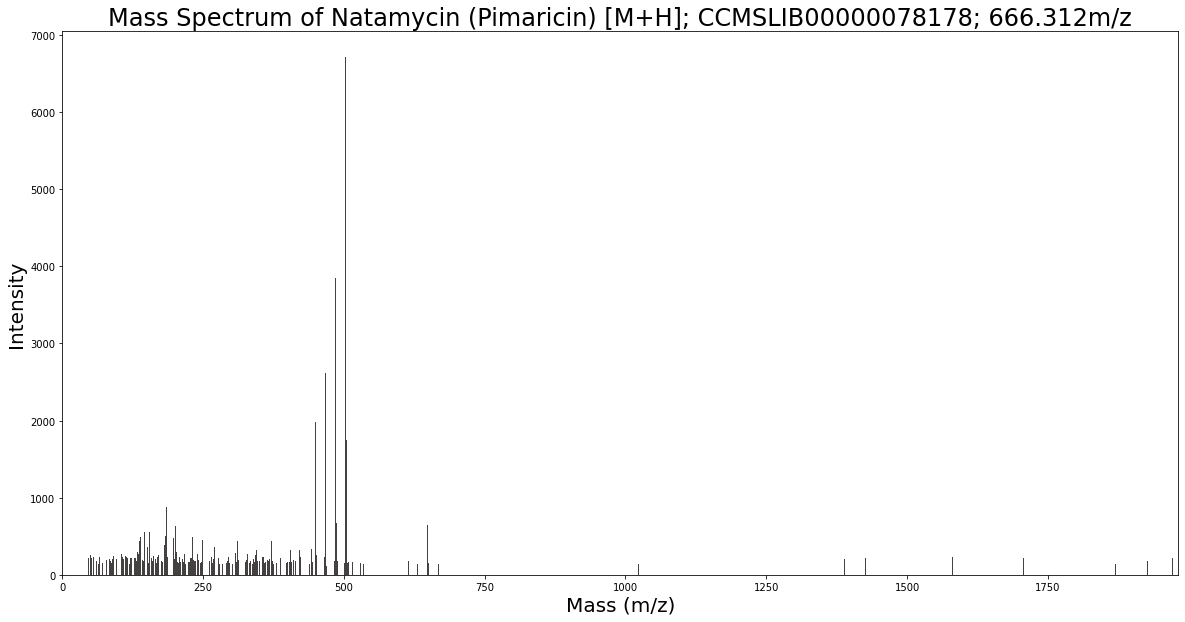

In [41]:
# Display the spectra
display_spectra(natamycin_spectra_1)

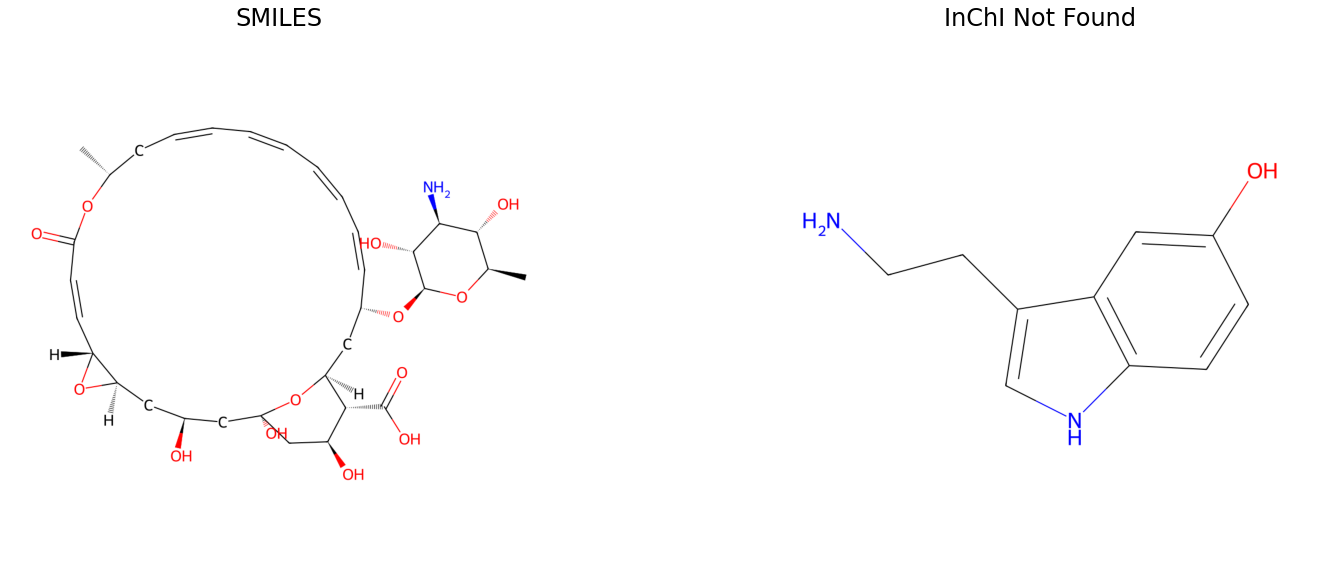

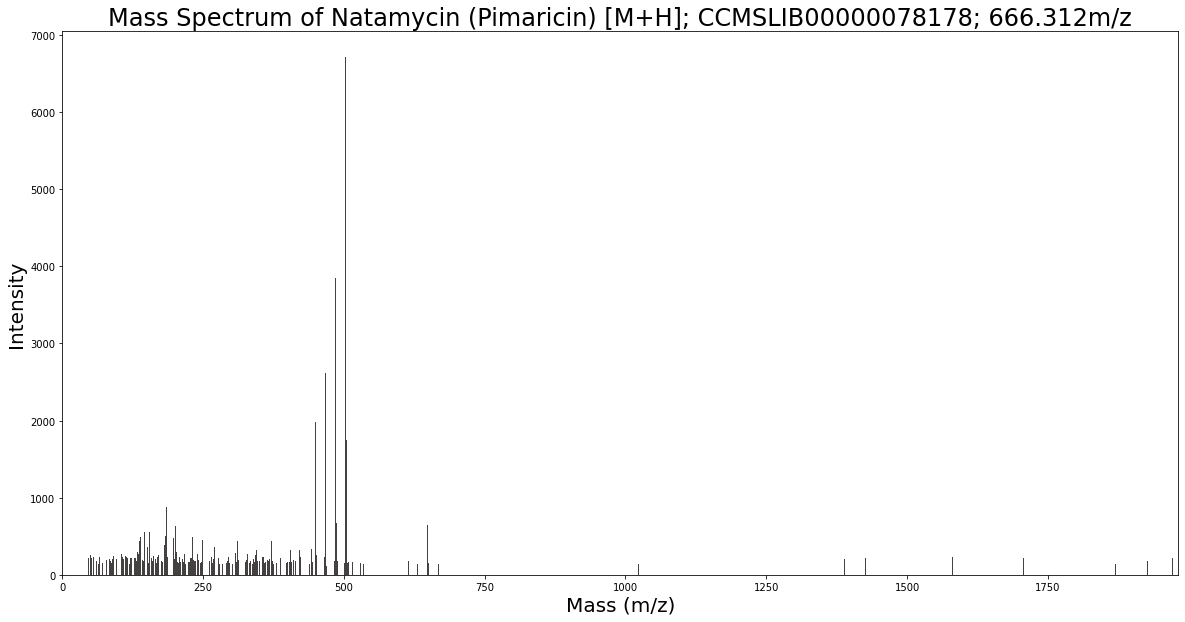

In [42]:
# Display the structure
display_structure(natamycin_matches[1][3], gnps_library)

In [ ]:
# Write the spectra to a .mgf file (write_mgf(spectra, GNPS_ID, ion, output_path))
write_mgf(natamycin_spectra_1, natamycin_matches[1][3], "H", "YOUR OUTPUT PATH HERE")